# Mid Term 1 - KNN & Logistic Regression
*Authors*:  
- Aliotta Lorenzo, S5655762
- Prataiolo Loris, S


### Libraries and utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator
import time

In [2]:
ds1 = np.load("synthetic_linear_gaussian/linsep_d2_n200.npz")     # (d = 2 ;  n = 200)
ds2 = np.load("synthetic_linear_gaussian/linsep_d10_n1000.npz")   # (d = 10;  n = 1000)
ds3 = np.load("synthetic_linear_gaussian/linsep_d500_n50000.npz") # (d = 500; n = 50000)

In [3]:
print(ds1.files)

['X_train', 'y_train', 'X_test', 'y_test', 'w_true', 'b_true', 'flip_mask', 'noise_rate', 'seed', 'feature_dim', 'n_samples', 'test_size']


In [4]:
def _check_random_generator(rng: int | Generator | None) -> Generator:
    """Convert rng into a np.random.Generator instance."""
    if rng is None:
        print("⚠️  Warning: Set the `rng` parameter to a NumPy random generator\n"
              "   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure\n"
              "   your results are reproducible. Proceeding with a random seed for now.")
        return np.random.default_rng()
    if isinstance(rng, np.random.Generator):
        return rng
    if isinstance(rng, (int, np.integer)):
        return np.random.default_rng(rng)

### Datasets loading

In [4]:
ds1 = np.load("synthetic_linear_gaussian/linsep_d2_n200.npz")     # (d = 2 ;  n = 200)
ds2 = np.load("synthetic_linear_gaussian/linsep_d10_n1000.npz")   # (d = 10;  n = 1000)
ds3 = np.load("synthetic_linear_gaussian/linsep_d500_n50000.npz") # (d = 500; n = 50000)

# KNN

## Methods

In [77]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

In [78]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

In [79]:
def allDistances(X1, X2):
    '''
    Compute pairwise Euclidean distnaces between two X sets.
    output: D :=  A matrix (X1_rows x X2_rows) where D[i, j] equals the Euclidean distance 
                  between the i-th sample in X1 and the j-th sample in X2.
    '''
    D = np.zeros((X1.shape[0], X2.shape[0]))

    for i in range(X1.shape[0]):
        for j in range (X2.shape[0]):
            D[i,j] = euclidDistance(X1[i,:], X2[j,:])
            
    return D

In [80]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0]  # number of the training inputs
    n_test  = Xte.shape[0]  # number of the test inputs

    # sanity checks
    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # Compute all the distances from TEST input and TRAINING input
    dist = allDistances(Xte,Xtr)
    
    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):

        # Take all distances for the current test point and sort them 
        idx_dist = dist[idx, :]     
        idx_sort = np.argsort(idx_dist)
        
        # Get the indices of the k lowest of distances
        k_dist_index = idx_sort[:k]
        
        # Compute the mean of the output values of the corresponding training points and taking the sign of it.
        mean = np.mean(Ytr[k_dist_index])

        Ypred[idx] = np.sign(mean) # returns -1 if x < 0, 0 if x==0, 1 if x > 0
    return Ypred

In [81]:
def KFoldCVkNN(Xtr, Ytr, num_folds, k_list, rng: int | Generator | None = None):
    """Run K-Fold CV for the kNN model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - k_list : List[int]
         the values of k (for k-NN) to try
     - rng : Optional[int | Generator | None]
         optional random state

    Returns:
    --------
     - best_k : int
         The value of k (in k_list) which obtains the best average validation error
     - best_k_idx : int
         The index of the best_k element in k_list
     - tr_err_mean : np.array
         A 1D array of the same length as k_list, with the average training error for each tested k.
     - tr_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation 
         of the training error for each tested k.
     - val_err_mean : np.array
         A 1D array of the same length as k_list, with the average validation error for each tested k.
     - val_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation
         of the validation error for each tested k.
    """
    rng = _check_random_generator(rng)
    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = len(k_list)

    n_tot = Xtr.shape[0]

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, num_folds)) # train
    val_errors = np.zeros((num_k, num_folds)) # validation

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rng.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds) 
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        
        # Split training set in training part and validation part
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]

        x_val   = Xtr[val_mask==True]
        y_val   = Ytr[val_mask==True]
        
        for k_idx, current_k in enumerate(k_list):
            # Compute the training error of the kNN classifier for the given value of k
            Tpred = kNNClassify(x_train, y_train, current_k, x_train)
            tr_errors[k_idx, fold_idx] = calcError(Tpred, y_train)
            
            # Compute the validation error of the kNN classifier for the given value of k
            Vpred = kNNClassify(x_train, y_train, current_k, x_val)
            val_errors[k_idx, fold_idx] = calcError(Vpred, y_val)
            
    # Calculate error statistics along the repetitions:
    # compute mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)

    # compute mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    
    # compute the best k (k which minimize mean validation error) and index of best k in k_list
    best_k = k_list[np.argmin(val_err_mean)]
    best_k_idx = np.where(k_list == best_k)
    
    return best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std

In [82]:
def plot_training_validation_error_mean (k_list, val_err_mean, val_err_std, tr_err_mean, tr_err_std, num_folds):
    fig, ax = plt.subplots()
    ax.plot(k_list, val_err_mean, label="Validation")
    ax.fill_between(k_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
    ax.plot(k_list, tr_err_mean, label="Training")
    ax.fill_between(k_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)
    
    ax.set_title(f"{num_folds}-Fold CV")
    ax.set_ylabel("Error")
    ax.set_xlabel("k Values")
    ax.legend()

In [83]:
def perform_knn_process(dataset,  rng: int | Generator | None = None):

    Xtr = dataset['X_train']
    Xte = dataset['X_test']
    Ytr = dataset['y_train']
    Yte = dataset['y_test']

    k_values = np.arange(1,32,2)
    num_folds = 5

    best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(Xtr, Ytr, num_folds=num_folds, k_list=k_values, rng=rng)

    plot_training_validation_error_mean(k_values, val_err_mean, val_err_std, tr_err_mean, tr_err_std, num_folds)
    
    # evaluate the error for training set and test set using the best k
    # and estimate the performing time of KNN Classifier
    
    tr_start = time.perf_counter()
    tr_pred = kNNClassify(Xtr, Ytr, best_k, Xtr)
    tr_end   = time.perf_counter()
    
    te_start = time.perf_counter()
    te_pred = kNNClassify(Xtr, Ytr, best_k, Xte)
    te_end   = time.perf_counter()

    # accuracy
    tr_error = calcError(tr_pred, Ytr)
    te_error = calcError(te_pred, Yte)

    print(f"Best K: {best_k}\n")
    print("=== TRAINING STAT ===")
    print(f"Accuracy (error): {tr_error*100:.3f}%")
    print(f"Execution Time: {tr_end-tr_start:.8f} seconds\n")
    
    print("=== TEST STAT ===")
    print(f"Accuracy (error): {te_error*100:.3f}%")
    print(f"Execution Time: {te_end-te_start:.8f} seconds")

## Test on datasets

Best K: 27

=== TRAINING STAT ===
Accuracy (error): 12.000%
Execution Time: 0.07456412 seconds

=== TEST STAT ===
Accuracy (error): 14.000%
Execution Time: 0.02552046 seconds


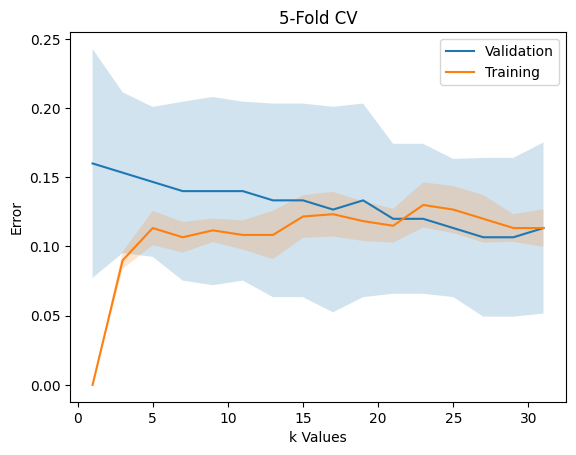

In [84]:
rng = np.random.default_rng(45)
perform_knn_process(ds1 , rng=rng)

Best K: 31

=== TRAINING STAT ===
Accuracy (error): 16.000%
Execution Time: 2.86949930 seconds

=== TEST STAT ===
Accuracy (error): 17.600%
Execution Time: 0.83290990 seconds


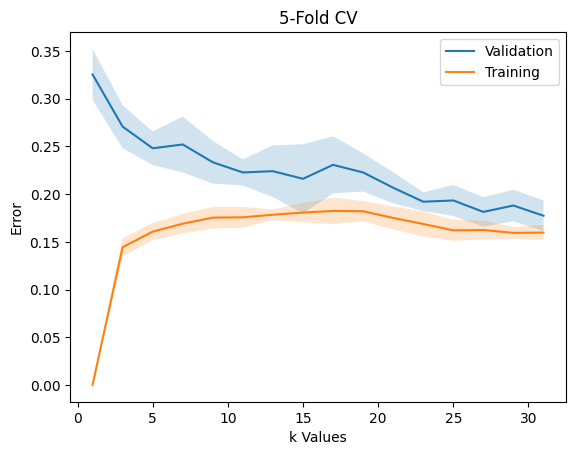

In [85]:
perform_knn_process(ds2, rng=rng)

In [ ]:
perform_knn_process(ds3, rng=rng)

# Logistic Regression

## Methods

In [60]:
# Estimate the gamma parameter: the optimal learning rate for gradient descent
def optimal_gd_learning_rate(Xtr, reg_par):
    eigvals = np.linalg.eigvalsh(Xtr.T @ Xtr)
    # Calculate L: the Lipschitz constant of the gradient
    L = np.max(eigvals) / Xtr.shape[0] + 2 * reg_par
    gamma = 1 / L
    return gamma

In [71]:
def train_logreg_gd(Xtr, Ytr, reg_par, epsilon = 1e-6, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    epsilon :  the tolerance for the stopping criterion
    maxiter : the maximum number of gradient-descent iterations
    """
    # size of the input in the training
    n, D = np.shape(Xtr)

    # initialization of the vector w
    w = np.zeros((D, 1))

    # Set the learning rate optimally
    gamma = optimal_gd_learning_rate(Xtr, reg_par)

    # initialization of some supporting variables
    j = 0
    loss_old = 0
    loss = float("inf")
    Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
       
    while j < maxiter and abs(loss - loss_old) >= epsilon:
        loss_old = loss

        # Update the weights and compute the loss
        temp = 0
        loss = 0
        
        for i in np.arange(n):
            temp = temp - Ytr[i]*Xtr[i] / (1+np.exp(Ytr[i] * np.dot(Xtr[i], w)))
            loss = loss + np.log(1 + np.exp(-Ytr[i] * w.T @ Xtr[i]))
            
        temp = temp.reshape(-1, 1)
        w = w - gamma * (temp/n + 2*reg_par*w)

        loss = loss / n + reg_par * (w.T @ w)
        j = j + 1
    
    return w

In [72]:
def predict_logreg(weights, X):
    """
    weights : array of shape d, 1
    X : array of shape n, d
    """
    ypred = np.dot(X, weights)
    ppred = 1 / (1 + np.exp(-ypred))
    # The outputs are reshaped to be 1D vectors
    return np.sign(ypred).reshape(-1)

In [73]:
def calcErrorLR(Ypred, Y):
    return np.mean(Ypred != Y)

In [74]:
def KFoldCVLR(Xtr, Ytr, num_folds, lam_list, epsilon=1e-6, maxiter=100, rng: int | Generator | None = None):
    """Run K-Fold CV for the linear regression model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - lam_list : List[int]
         the values of lambda (for LR) to try
     - rng : Optional[int | Generator | None]
         optional random state

    Returns:
    --------
     - best_lam : int
         The value of lam (in lam_list) which obtains the best average validation error
     - best_lam_idx : int
         The index of the best_lam element in lam_list
     - tr_err_mean : np.array
         A 1D array of the same length as lam_list, with the average training error for each tested lam.
     - tr_err_std : np.array
         A 1D array of the same length as lam_list, with the standard deviation 
         of the training error for each tested lam.
     - val_err_mean : np.array
         A 1D array of the same length as lam_list, with the average validation error for each tested lam.
     - val_err_std : np.array
         A 1D array of the same length as lam_list, with the standard deviation
         of the validation error for each tested lam.
    """
    rng = _check_random_generator(rng)
    # Ensures that lam_list is a numpy array
    lam_list = np.array(lam_list)
    num_lam = len(lam_list)

    n_tot = Xtr.shape[0]

    # We want to compute 1 error for each `lambda` and each fold
    tr_errors = np.zeros((num_lam, num_folds))
    val_errors = np.zeros((num_lam, num_folds))

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rng.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        # Split training set in training part and validation part
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]
        x_val = Xtr[val_mask==True]
        y_val = Ytr[val_mask==True]
        
        for lam_idx, current_lam in enumerate(lam_list):
            # Compute the predicted w with the current lambda
            wpred = train_logreg_gd(x_train, y_train, current_lam, epsilon, maxiter)
            # Compute the training error of the LR classifier for the given value of lambda
            y_tr_pred = predict_logreg(wpred, x_train)
            tr_errors[lam_idx, fold_idx] = calcErrorLR(y_tr_pred, y_train)
            # Compute the validation error of the LR classifier for the given value of lambda
            y_val_pred = predict_logreg(wpred, x_val)
            val_errors[lam_idx, fold_idx] = calcErrorLR(y_val_pred, y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)
    # 2) mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    # 3) best lambda (lambda which minimize mean validation error) and index of best lambda in lam_list
    best_lam = lam_list[np.argmin(val_err_mean)]
    best_lam_idx = np.where(lam_list == best_lam)
    
    return best_lam, best_lam_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std

In [75]:
def plotErrorsCVLR(reg_pars, best_lam, tr_err_mean, tr_err_std, val_err_mean, val_err_std, num_folds):
    # Plot the training and validation error
    fig, ax = plt.subplots()
    ax.plot(reg_pars, val_err_mean, label="Validation")
    ax.fill_between(reg_pars, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
    ax.plot(reg_pars, tr_err_mean, label="Training")
    ax.fill_between(reg_pars, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

    ax.axvline(x=best_lam, color='g', lw=1)

    ax.set_ylim(bottom=max(min(min(val_err_mean - val_err_std), min(tr_err_mean - tr_err_std))-0.01, 0), top=min(max(max(val_err_mean + val_err_std), max(tr_err_mean + tr_err_std))+0.01, 1))
    ax.set_title(f"{num_folds}-Fold CV")
    ax.set_ylabel("Error")
    ax.set_xlabel("lambda")
    ax.set_xscale("log")
    ax.legend()

In [77]:
def dataLearnLR(dataset, reg_pars = np.logspace(-6, 1, 10), epsilon=1e-6, maxiter=100, num_folds=5, rng: int | Generator | None = None):

    Xtr = dataset['X_train']
    Xte = dataset['X_test']
    Ytr = dataset['y_train']
    Yte = dataset['y_test']

    best_lam, best_lam_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVLR(Xtr, Ytr, num_folds, reg_pars, epsilon, maxiter, rng)

    print(f"The best lambda selected is: {best_lam}")
    plotErrorsCVLR(reg_pars, best_lam, tr_err_mean, tr_err_std, val_err_mean, val_err_std, num_folds)
    
    # evaluate the error for training set and test set using the best lambda
    # and estimate the performing time of the linear regression model
    
    time_start = time.perf_counter()
    wpred = train_logreg_gd(Xtr, Ytr, best_lam, epsilon, maxiter)
    time_end = time.perf_counter()

    Ytr_pred = predict_logreg(wpred, Xtr)
    Yte_pred = predict_logreg(wpred, Xte)
    
    tr_error = calcErrorLR(Ytr_pred, Ytr)
    te_error = calcErrorLR(Yte_pred, Yte)

    print(f"The training time is: {time_end-time_start:.8f} seconds")
    print(f"The training error is: {tr_error*100:.3f}%")
    print(f"The test error is: {te_error*100:.3f}%")

## Test on datasets

The best lambda selected is: 1e-06
The training time is: 0.09103354 seconds
The training error is: 10.667%
The test error is: 12.000%


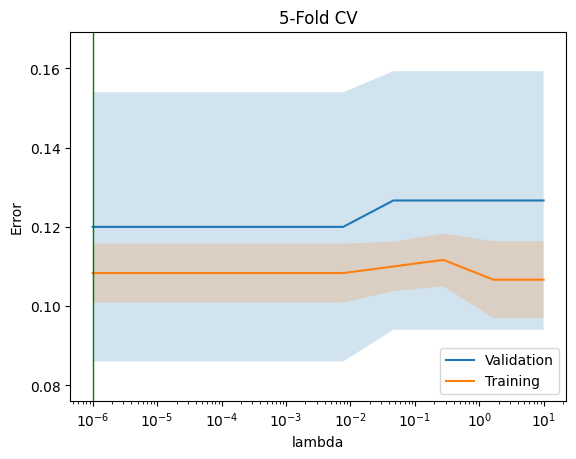

In [78]:
random_seed = 2306

dataLearnLR(ds1, rng=random_seed)

The best lambda selected is: 0.007742636826811269
The training time is: 0.45049592 seconds
The training error is: 12.533%
The test error is: 13.600%


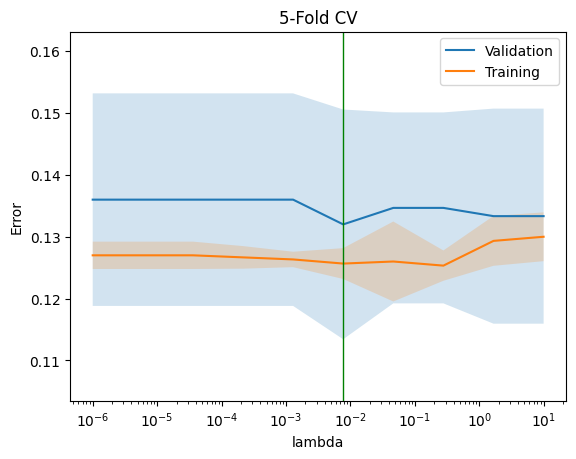

In [68]:
dataLearnLR(ds2, rng=random_seed)

The best lambda selected is: 1e-06
The training time is: 27.34569683 seconds
The training error is: 12.491%
The test error is: 13.768%


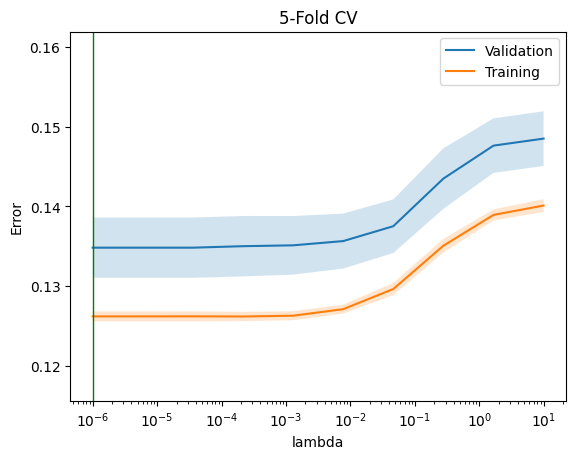

In [23]:
dataLearnLR(ds3, rng=random_seed)